In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
import sys
import shutil
from shutil import copyfile, copy2
from shutil import move

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from scipy import stats
# Cause plots to be displayed in the notebook:
%matplotlib inline

In [4]:
import subprocess 

In [4]:
from matplotlib import cm
from latt2D_modules import calc_diffuse_cfs3
from latt2D_modules import get_occ_map, get_2D_occ_map_from_seq,store_occ_map_as_seq
from latt2D_modules import plot_occ_map,read_bin,output_16bit_pgm
import time

In [5]:
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [13]:

iconc=0.50 # spin concentration
cread=0    # reading correlation function from input file  otherwise it will be generated randomly 
'corr.in'
'jswitch.in'
icycles=500  # MC cycles 
ianneal=500  # MC input 


corrin=np.array([[1.0,  0.0, 0.0], 
                 [0.0,  0.0, 0.0], 
                 [0.0,  0.0, 0.0]])

fhout=open('corr.in','w')
fhout.write("%.6f %.6f %.6f\n%.6f %.6f %.6f\n%.6f %.6f %.6f\n"%(tuple(corrin.flatten())))
fhout.close()

jsw=np.ones((9)) 
        

fhout=open('jswitch.in','w')
fhout.write("%d %d %d\n%d %d %d\n%d %d %d\n"%tuple(jsw))
fhout.close()




### Do a Preliminary test 
### generate as random image

In [14]:
calc_diffuse_cfs3(iconc,cread,icycles,ianneal,exp_no=0)
# store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt','./expfiles_0/ising2D_seq.dat')

Correlation function configuration
 00: 1.000  01: -0.414  02: -0.141 
 10: 0.272  11: -0.346  12: 0.288 
 20: -0.326  21: 0.277  22: -0.275 



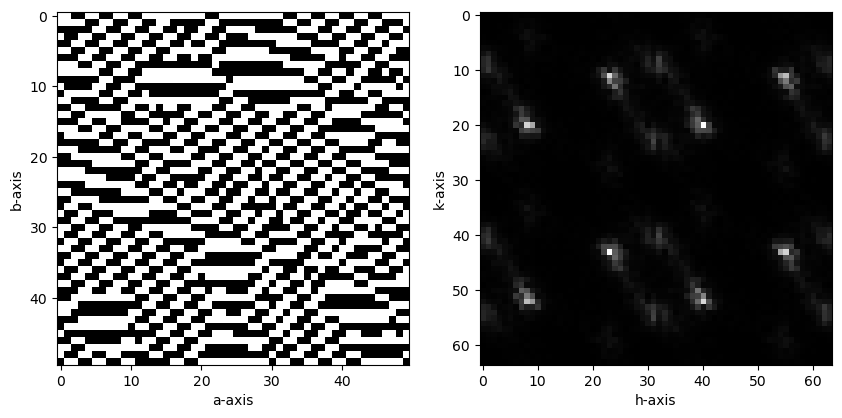

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
occ3D=get_occ_map('./expfiles_0/ising2D_occ.txt')
store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt','./expfiles_0/ising2D_seq.dat')
axes[0].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
axes[0].set_xlabel('a-axis')
axes[0].set_ylabel('b-axis')
imdat = read_bin('./expfiles_0/hk0.bin', npixels=64, offset=1280)
axes[1].imshow(np.flip(imdat,0),cmap='gray')
axes[1].set_xlabel('h-axis')
axes[1].set_ylabel('k-axis')
corr_out=np.loadtxt('expfiles_0/corr.out')
print("Correlation function configuration")
print(" 00: %.3f  01: %.3f  02: %.3f \n 10: %.3f  11: %.3f  12: %.3f \n 20: %.3f  21: %.3f  22: %.3f \n"%tuple(corr_out.flatten()))

#### below is a check to see how the reinput changes - in future we can check using a few differnt metrics 
#### but for the time being the correlation function will act as the decoder for generating the crystal  

Correlation function configuration
 00: 1.000  01: -0.421  02: -0.139 
 10: 0.259  11: -0.352  12: 0.298 
 20: -0.333  21: 0.277  22: -0.261 



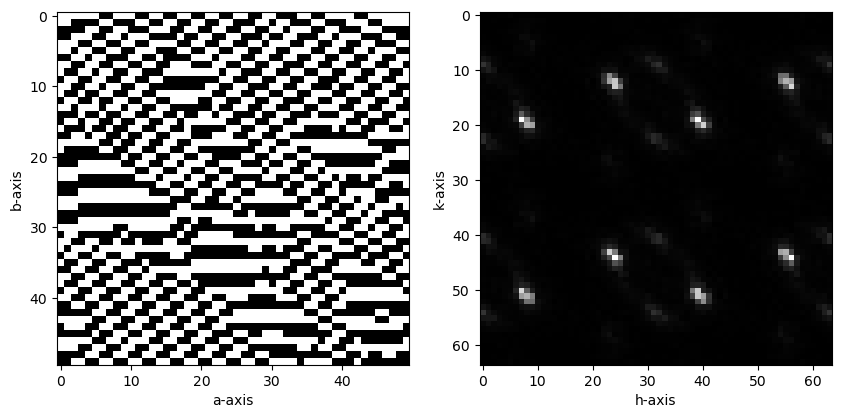

In [16]:
copyfile('expfiles_0/corr.out','./corr.in')
calc_diffuse_cfs3(iconc,1,icycles,ianneal,1)
store_occ_map_as_seq('./expfiles_1/ising2D_occ.txt','./expfiles_1/ising2D_seq.dat')
fig, axes = plt.subplots(1, 2, figsize=(10,6))
occ3D=get_occ_map('./expfiles_1/ising2D_occ.txt')
axes[0].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
axes[0].set_xlabel('a-axis')
axes[0].set_ylabel('b-axis')
imdat = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
axes[1].imshow(np.flip(imdat,0),cmap='gray')
axes[1].set_xlabel('h-axis')
axes[1].set_ylabel('k-axis')
corr_out=np.loadtxt('expfiles_1/corr.out')
print("Correlation function configuration")
print(" 00: %.3f  01: %.3f  02: %.3f \n 10: %.3f  11: %.3f  12: %.3f \n 20: %.3f  21: %.3f  22: %.3f \n"%tuple(corr_out.flatten()))

### Lets calculate an accuracy and MSE for the correaltion functions as well as the images 
### we will use this as a modified baseline accuracy since the binary grid will also have intrinsic baseline acc 

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [22]:
occ2D_0=get_2D_occ_map_from_seq('./expfiles_0/ising2D_seq.dat')
occ2D_1=get_2D_occ_map_from_seq('./expfiles_1/ising2D_seq.dat')
accuracy=sum(occ2D_0==occ2D_1)/len(occ2D_0.flatten())
print("Ising2D accuracy:", accuracy)
corr_out_0=np.loadtxt('expfiles_0/corr.out')
corr_out_1=np.loadtxt('expfiles_1/corr.out')
imdat_0 = read_bin('./expfiles_0/hk0.bin', npixels=64, offset=1280)
imdat_1 = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
print("MSE correlation config: ", mean_squared_error(corr_out_0.flatten(),corr_out_1.flatten()))
print("MSE FT images: ", mean_squared_error(imdat_0.flatten(),imdat_1.flatten()))

Ising2D accuracy: [0.0116 0.0104 0.0108 0.0124 0.0092 0.0124 0.0084 0.0112 0.0088 0.0072
 0.0104 0.0064 0.0092 0.0084 0.0064 0.0096 0.0092 0.01   0.0096 0.01
 0.008  0.0108 0.0076 0.0088 0.0084 0.008  0.0072 0.008  0.0084 0.0088
 0.0092 0.006  0.0084 0.0076 0.0088 0.0044 0.0124 0.006  0.0128 0.0076
 0.0104 0.0088 0.0108 0.0084 0.0092 0.0076 0.008  0.0072 0.008  0.0076]
MSE correlation config:  6.538045555555557e-05
MSE FT images:  0.21748914


## The below cell will generate random images which can be used for training a CNN
## The correlations are stored in a dataframe which is then saved as a .csv 

In [40]:
# %%timeit # you need to be careful with this becasue magic function acts like wrapper and screws with variable locality
# in fact its running the loop several times to get an average - if you want the time for a single run just import time
iconc=0.50 # spin concentration
cread=0    # reading correlation function from input file  otherwise it will be generated randomly 
icycles=300  # MC cycles 
ianneal=300  # MC input 

start_time = time.time()
# when possible always dump to a list or array before converting to Dataframe
N=5000 # make this many images
Nstart=0 # start labels here
corrfuncs=[]
for i in range(N):
    k=i+Nstart
    calc_diffuse_cfs3(iconc,0,icycles,ianneal,exp_no=0)
    copyfile('./expfiles_0/hk0.bin','./cfs3_image_inputs_bin/hk0_%s.bin'% str(k).zfill(6))
    store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt','./cfs3_image_inputs_seq/ising2D_seq_%s.dat' %  str(k).zfill(6))
    # dont save the full occfile unless needed - since this takes up resources 
    # copyfile('./expfiles_0/ising2D_occ.txt','./image_inputs_occ/ising2D_occ_%d.txt'%(i))  
    corr_out=np.loadtxt('expfiles_0/corr.out')
    corrfuncs.append(corr_out.flatten())
    
end_time = time.time()
total_time = end_time - start_time

print("Total time taken: {:.2f} seconds".format(total_time))

Total time taken: 4799.41 seconds


### dont forget to relabel the DF if you are making a new batch
for 5000 images Total time taken: 4799.41 seconds

In [41]:
df=pd.DataFrame(corrfuncs)
df.columns=['00','01','02','10','11','12','20','21','22']
df.to_csv('output_correlations_cfs3_5000.csv')
df.head()

,00,01,02,10,11,12,20,21,22
0,0.998976,0.307776,-0.370624,0.366976,0.205376,0.074176,0.430976,-0.033024,-0.383424
1,0.999744,-0.403456,0.266944,-0.022656,-0.094656,-0.440256,0.258944,-0.720256,0.486144
2,0.999997,0.001597,0.323197,0.417597,-0.009603,-0.110403,-0.164803,-0.337603,-0.184003
3,0.997379,-0.244221,-0.426621,-0.103421,-0.493821,0.571779,0.106179,-0.183421,0.213379
4,0.999994,0.105594,-0.182406,0.212794,-0.366406,-0.036806,-0.459206,-0.152006,-0.251206


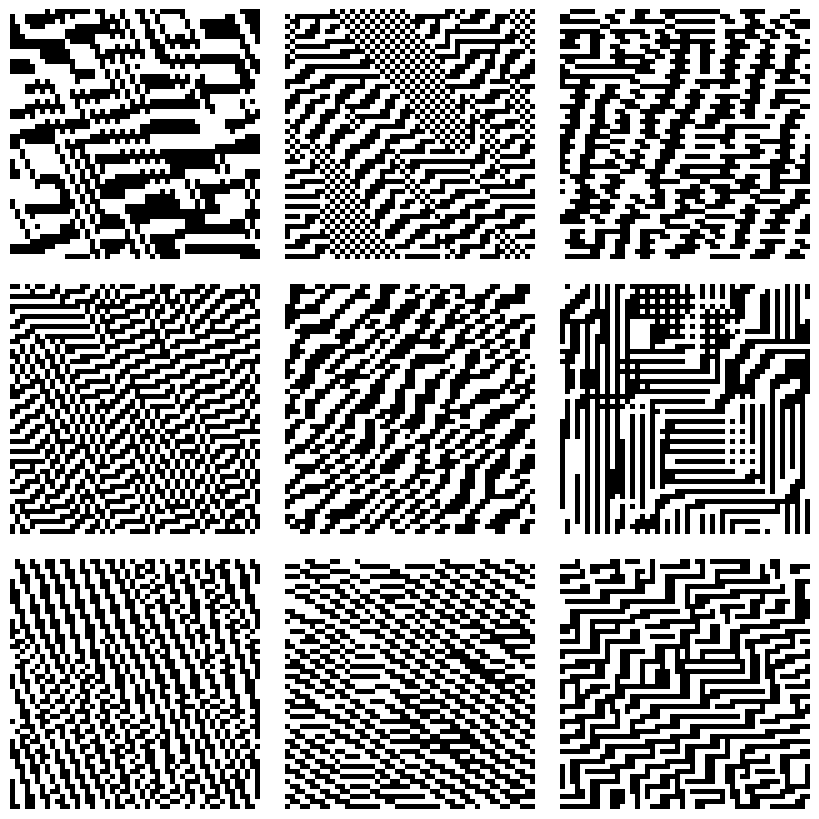

In [6]:
rows,cols =3,3 
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
Nstart=0 # start labels here
k=0
for i in range(rows): 
    for j in range(cols):
        # occ3D=get_occ_map('./image_inputs_occ/ising2D_occ_%d.txt'%(k))
        # axes[i,j].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap=my_cmap) 
        occ2D=get_2D_occ_map_from_seq('./cfs3_image_inputs_seq/ising2D_seq_%s.dat'%str(k+Nstart).zfill(6))
        axes[i,j].imshow(np.transpose(occ2D),interpolation='nearest',cmap='gray') 
        axes[i,j].axis('off')
        # axes[i,j].set_xlabel('a-axis')
       # axes[i,j].set_ylabel('b-axis')

        k+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)


In [ ]:
rows,cols =3,3 
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
Nstart=0 # start labels here
k=0
for i in range(rows): 
    for j in range(cols):
        imdat = read_bin('./cfs3_image_inputs_bin/hk0_%s.bin'%str(k+Nstart).zfill(6), npixels=64, offset=1280)
        axes[i,j].imshow(np.flip(imdat,0),cmap='gray')
        axes[i,j].set_xlabel(None)
        axes[i,j].axis('off')
        k+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)

## below is test code 

In [180]:
# this stores the output simualtion as a string of ones and zeros
x=np.loadtxt('./expfiles_0/ising2D_occ.txt',usecols=[4])
fhout=open('ising2D_seq.dat','w')
fhout.write(''.join(list((x-1).astype(int).astype(str))))
fhout.close()

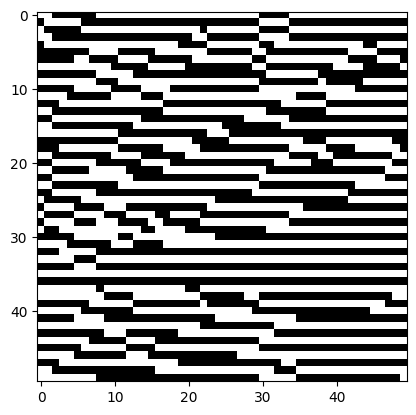

In [175]:
#. in order to plot we can read this back into a diffrent routine 
with open('ising2D_seq.dat','r') as f:
    myseq=f.read()
myocc=np.array(list(myseq)).astype(int).reshape((50,50))
plt.imshow(np.transpose(myocc),interpolation='nearest',cmap=my_cmap) 

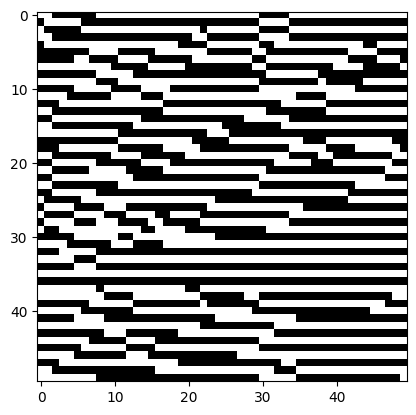

In [176]:
occ3D=get_occ_map('./expfiles_0/ising2D_occ.txt')
plt.imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap=my_cmap) 

In [177]:
df.tail()

,00,01,10,11
10,0.999969,0.012769,-0.331231,0.643169
11,0.997921,0.804321,0.674721,0.501921
12,0.999892,-0.003308,0.719892,-0.179308
13,0.999936,-0.656064,-0.726464,0.551936
14,0.999999,-0.672001,0.804799,-0.507201


In [182]:
store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt', 'ising2D_seq.dat')

In [183]:
occ2d=get_2D_occ_map_from_seq('ising2D_seq.dat')

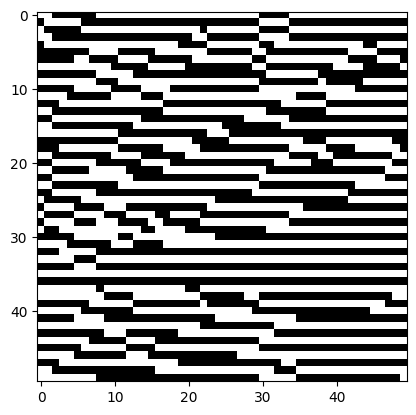

In [185]:
plt.imshow(np.transpose(occ2d),interpolation='nearest',cmap=my_cmap) 

In [19]:
# save the data as .h5

import h5py

# Set the path to your images directory
img_dir = "./cfs3_image_inputs_bin/"

# Set the size of your images
img_size = (64, 64)

# Set the path to where you want to save the HDF5 file
h5_file = "./cfs3_image_dataset_5000.h5"

nfiles=5000
Nstart=0 
# Create a new HDF5 file
with h5py.File(h5_file, 'w') as hf:

    # Create a dataset to store your image data
    img_data = hf.create_dataset('cfs3_img_data', shape=(nfiles, *img_size), dtype=np.float64)

    # Loop through each image file
    for i in range(nfiles):    
        
        # Convert the image to a numpy array
        img_arr =read_bin(img_dir+'hk0_%s.bin'%str(i+Nstart).zfill(6), npixels=64, offset=1280)
        
        # Store the image data in the dataset
        img_data[i] = img_arr

# Print a message indicating the dataset has been created
print("Dataset created in {}".format(h5_file))


Dataset created in ./image_dataset_1000.h5


In [24]:
# save the 5000 data images as .h5

import h5py

# Set the path to your images directory
img_dir = "./image_inputs_bin/"

# Set the size of your images
img_size = (64, 64)

# Set the path to where you want to save the HDF5 file
h5_file = "./image_dataset_5000.h5"

nfiles=5000
Nstart=0 
# Create a new HDF5 file
with h5py.File(h5_file, 'w') as hf:

    # Create a dataset to store your image data
    img_data = hf.create_dataset('img_data', shape=(nfiles, *img_size), dtype=np.float64)

   
    # Loop through each image file
    for i in range(nfiles):    
        
        # Convert the image to a numpy array
        img_arr =read_bin(img_dir+'hk0_%s.bin'%str(i+Nstart).zfill(6), npixels=64, offset=1280)
        
        # Store the image data in the dataset
        img_data[i] = img_arr

        
        
# Print a message indicating the dataset has been created
print("Dataset created in {}".format(h5_file))


Dataset created in ./image_dataset_5000.h5


In [20]:
# Open the HDF5 file in read-only mode
with h5py.File('image_dataset_1000.h5', 'r') as f:
    # Get a list of dataset names in the HDF5 file
    dataset_names = list(f.keys())
    
    # Print the names of all datasets
    for name in dataset_names:
        print(name)
    dset=f['img_data']
    X=dset[:]

img_data


In [21]:
np.shape(X)

(1000, 64, 64)

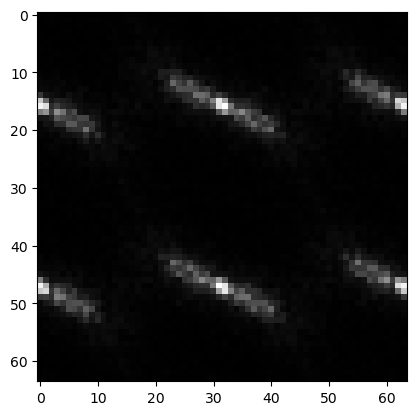

In [22]:
imshow(np.flip(X[0],0),cmap='gray')

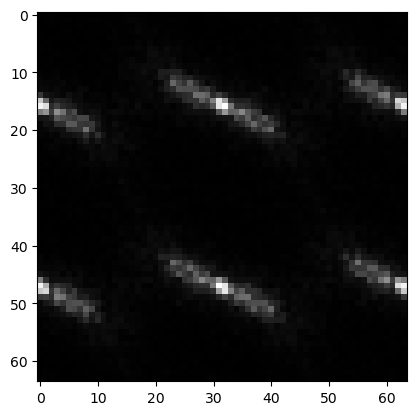

In [23]:
k=0
imdat = read_bin('./image_inputs_bin/hk0_%s.bin'%str(k).zfill(6), npixels=64, offset=1280)
imshow(np.flip(imdat,0),cmap='gray')